In [1]:
#from IPython.parallel import Client
from ipyparallel import Client
#c = Client()
c = Client(profile='parallel_python2.7')
dview = c.direct_view()
lview = c.load_balanced_view()

In [13]:
with dview.sync_imports():
    import numpy
    from mitgcmdata import MITgcmmodel, layers, budgets
    from jmd95 import eos
    from MITgcmutils import mds
    import os
from matplotlib import pyplot as plt
import xray
%matplotlib inline

importing numpy on engine(s)
importing MITgcmmodel,layers,budgets from mitgcmdata on engine(s)
importing eos from jmd95 on engine(s)
importing mds from MITgcmutils on engine(s)
importing os on engine(s)


In [5]:
%%px --local
ddir = '/data/scratch/rpa/SOSE/run_matt'
#ddir = '/glade/scratch/rpa/SOSE/run_matt_layers'

layers_name = '1RHO'

m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter=480)

extra_mask = numpy.zeros(m.shape, dtype='bool')
extra_mask[:,-1] = 1

Slevs = numpy.linspace(32,38,200)

gam_levs = numpy.linspace(22,28.5,330)
Nrho2 = len(gam_levs)
drho = numpy.diff(gam_levs)
rholevs = gam_levs

2160 320  42
[stdout:0] 2160 320  42
[stdout:1] 2160 320  42
[stdout:2] 2160 320  42
[stdout:3] 2160 320  42
[stdout:4] 2160 320  42
[stdout:5] 2160 320  42
[stdout:6] 2160 320  42
[stdout:7] 2160 320  42


In [6]:
%%px --local
dmask = 19
dsuf = '%04d' % -m.zf[dmask]
print dsuf

0671
[stdout:0] 0671
[stdout:1] 0671
[stdout:2] 0671
[stdout:3] 0671
[stdout:4] 0671
[stdout:5] 0671
[stdout:6] 0671
[stdout:7] 0671


In [7]:
N = 438

iter0 = 480
diters= 480
deltaTclock = 900
all_iters = range(iter0, iter0+diters*N, diters)
dview.scatter('iters', all_iters)

<AsyncResult: finished>

In [8]:
%%px
print len(iters)

[stdout:0] 55
[stdout:1] 55
[stdout:2] 55
[stdout:3] 55
[stdout:4] 55
[stdout:5] 55
[stdout:6] 54
[stdout:7] 54


In [9]:
%%px
print extra_mask.dtype

[stdout:0] bool
[stdout:1] bool
[stdout:2] bool
[stdout:3] bool
[stdout:4] bool
[stdout:5] bool
[stdout:6] bool
[stdout:7] bool


In [17]:
%%px
# load b factor and reference pressure
PHref = mds.rdmds(os.path.join(ddir,'PHrefC'))
pref = PHref.squeeze() / 9.81
b_fac = numpy.load('/home/rpa/sose_water_mass_transformation/SOSE_layers_analysis/b_factor.npy')
new_ddir = '/data/scratch/rpa/SOSE/matt_iter100'

In [ ]:
%%px

# mask everything below 670 m depth
extra_mask[dmask+1:] = True

res = []
for i in iters:
    
    theta = m.rdmds('SOstt_5d', i, rec=0)
    salt = m.rdmds('SOstt_5d', i, rec=1)
    
    rho = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=(i-480)/480)
    rho = numpy.ma.masked_less(rho,20)
    drhodt = numpy.zeros_like(rho)
    drhods = numpy.zeros_like(rho)
    for k in range(m.Nz):
        _, a, b = eos.state(pref[k], theta[k].ravel(), salt[k].ravel())
        drhodt[k] = b_fac[k] * a.reshape((m.Ny, m.Nx))
        drhods[k] = b_fac[k] * b.reshape((m.Ny, m.Nx))
    
    salt_budget = budgets.TracerBudget(m,
                    'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                    iters=i)
    
    heat_budget = budgets.TracerBudget(m,
                'SO_Tbdg5', 'SO_Surf5d', trname='TH',
                swflux_name='oceQsw',
                swflux_fname='../run_np240/SO_Surf5d',
                iters=i)
    
    wmb = budgets.WaterMassBudget(m, rholevs, extra_mask=extra_mask)
    #trs, labels = wmb_salt.calc_transformation_rates(salt, salt_budget)
    wmt_salt, labels_salt = wmb.calc_transformation_rates(rho, salt_budget, scalefac=drhods)
    wmt_heat, labels_heat = wmb.calc_transformation_rates(rho, heat_budget, scalefac=drhodt)

    res.append([wmt_salt, wmt_heat])

In [8]:
%%px

print len(res)

[stdout:0] 55
[stdout:1] 55
[stdout:2] 55
[stdout:3] 55
[stdout:4] 55
[stdout:5] 55
[stdout:6] 54
[stdout:7] 54


In [23]:
allres_upper = dview.gather('res')

In [24]:
wmt_upper = allres_upper.get()
wmt_all = numpy.array([numpy.vstack([w[0], w[1]]) for w in wmt_upper])
wmt_salt_upper = numpy.array([w[0] for w in wmt_upper])
wmt_heat_upper = numpy.array([w[1] for w in wmt_upper])
print wmt_all.shape

(438, 15, 329)


In [27]:
labels_salt = dview['labels_salt'][0]
labels_heat = dview['labels_heat'][0]
labels_all = ['salt_' + l for l in labels_salt] + ['heat_' + l for l in labels_heat]

time = (numpy.datetime64('2005-01-01 00:00:00') + 
        numpy.array([numpy.timedelta64(deltaTclock, 's') * i for i in all_iters]))
gamman = rholevs[1:]
ds = xray.Dataset(coords={'gamman': gamman, 'time': time}, attrs={'depth_range': 'upper %g meters' % -m.zf[dmask]})

for n in range(len(labels_all)):
    ds[labels_all[n]] = xray.DataArray(wmt_all[:,n],
                        coords=[time, gamman], dims=('time', 'gamman'))

ds.to_netcdf('../data/wmt_gamma_upper_%sm.nc' % dsuf)

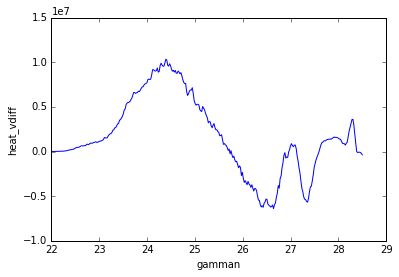

In [29]:

(ds.heat_vdiff).mean(dim='time').plot()
#plt.xlim(34,37.55)